In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf

SEED = 12
random.seed(SEED)

# 데이터

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

print(train.shape, test.shape, subm.shape)

(5497, 14) (1000, 13) (1000, 2)


In [ ]:
train.head(2)
# target : quality

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red


In [ ]:
subm.head()

,index,quality
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
train['type'].value_counts()

white    4159
red      1338
Name: type, dtype: int64

### 범주형 데이터 - 숫자형 데이터 변환

In [ ]:
train['type'] = np.where(train['type'] == 'white', 1, 0).astype(int)
test['type'] = np.where(test['type'] == 'white', 1, 0).astype(int)
train['type'].value_counts()

1    4159
0    1338
Name: type, dtype: int64

In [ ]:
train['quality'].value_counts()

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64

In [ ]:
from tensorflow.keras.utils import to_categorical
# 와인 등급을 범주형 데이터를 원핫 인코딩 변환
y_train = to_categorical(train.loc[:, 'quality'] - 3) # - 3 : 와인 등급을 0~6 으로 바꾼다.
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# 피처 선택
X_train = train.loc[:, 'fixed acidity':]
X_test = test.loc[:, 'fixed acidity':]

# 피처 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print(X_train_scaled)
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape)

[[0.14876033 0.41       0.03614458 ... 0.12359551 0.31884058 1.        ]
 [0.41322314 0.35333333 0.08433735 ... 0.20786517 0.2173913  0.        ]
 [0.33884298 0.08666667 0.23493976 ... 0.16853933 0.42028986 1.        ]
 ...
 [0.33057851 0.04666667 0.20481928 ... 0.28089888 0.47826087 1.        ]
 [0.23140496 0.22       0.18674699 ... 0.10674157 0.36231884 1.        ]
 [0.26446281 0.18       0.10240964 ... 0.07865169 0.24637681 1.        ]]
(5497, 12) (5497, 7)
(1000, 12)


### 드랍아웃
- 과대적합을 방지하기 위하여, 연결 중 일부를 랜덤으로 제거한 상태에서 학습하는 기법.
- 연결된 가중치 수를 줄이는 효과를 얻기 때문에 과대적합을 방지할 수 있음.

In [ ]:
# 심층 신경망 모델
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_model(train_data, train_target) :
  model = Sequential()
  model.add(Dense(128, activation='tanh', input_dim=train_data.shape[1]))
  model.add(Dropout(0.2))
  # 0.2 로 설정하면, 20% 확률로 랜덤하게 연결을 제거한다.
  # 은닉 레이어의 활성화 함수로 tanh 사용
  model.add(Dense(64, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='tanh'))
  # 다중 분류 모델이므로 마지막 활성화 함수는 softmax 적용
  model.add(Dense(train_target.shape[1], activation='softmax'))
  # 손실 함수 : categorical_crossentropy
  model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['acc', 'mae'])
  
  return model

model = build_model(X_train_scaled, y_train)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1664      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 7)                 231       
                                                                 
Total params: 12,231
Trainable params: 12,231
Non-trai

In [ ]:
###
# Early Stopping 기법
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

###
# 피처 선택
X_train = train.loc[:, 'fixed acidity':]
X_test = test.loc[:, 'fixed acidity':]

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, random_state=SEED)



In [ ]:
###
# 피처 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_tr)
X_train_scaled = scaler.fit_transform(X_tr)
X_test_scaled = scaler.fit_transform(X_test)

print(X_train_scaled)
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape)

[[0.23140496 0.15333333 0.1686747  ... 0.1011236  0.75362319 1.        ]
 [0.18181818 0.08       0.15662651 ... 0.26404494 0.20289855 1.        ]
 [0.33057851 0.27333333 0.29518072 ... 0.06179775 0.28985507 1.        ]
 ...
 [0.36363636 0.83333333 0.         ... 0.15168539 0.42028986 0.        ]
 [0.28099174 0.33333333 0.3253012  ... 0.19662921 0.33333333 0.        ]
 [0.37190083 0.38333333 0.07228916 ... 0.24719101 0.26086957 0.        ]]
(4672, 12) (5497, 7)
(1000, 12)


In [ ]:
###
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_scaled, y_tr, batch_size=62, epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/200
76/76 - 0s - loss: 1.4284 - acc: 0.4343 - mae: 0.1948 - val_loss: 1.1683 - val_acc: 0.5042 - val_mae: 0.1743 - 181ms/epoch - 2ms/step
Epoch 2/200
76/76 - 0s - loss: 1.1838 - acc: 0.4923 - mae: 0.1803 - val_loss: 1.6500 - val_acc: 0.4000 - val_mae: 0.1980 - 277ms/epoch - 4ms/step
Epoch 3/200
76/76 - 0s - loss: 1.1489 - acc: 0.5019 - mae: 0.1759 - val_loss: 1.8071 - val_acc: 0.3709 - val_mae: 0.2033 - 274ms/epoch - 4ms/step
Epoch 4/200
76/76 - 0s - loss: 1.1272 - acc: 0.5171 - mae: 0.1730 - val_loss: 1.8372 - val_acc: 0.3673 - val_mae: 0.2039 - 209ms/epoch - 3ms/step
Epoch 5/200
76/76 - 0s - loss: 1.1106 - acc: 0.5180 - mae: 0.1712 - val_loss: 1.8490 - val_acc: 0.3697 - val_mae: 0.2045 - 146ms/epoch - 2ms/step
Epoch 6/200
76/76 - 0s - loss: 1.1126 - acc: 0.5167 - mae: 0.1712 - val_loss: 1.9220 - val_acc: 0.3770 - val_mae: 0.2082 - 140ms/epoch - 2ms/step
Epoch 7/200
76/76 - 0s - loss: 1.1028 - acc: 0.5225 - mae: 0.1698 - val_loss: 1.8543 - val_acc: 0.3818 - val_mae: 0.2066 - 1

In [ ]:
# Early Stopping 기법
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.15, shuffle=True, random_state=SEED)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_tr, y_tr, batch_size=62, epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/200
76/76 - 1s - loss: 1.2840 - acc: 0.4623 - mae: 0.1914 - val_loss: 1.1684 - val_acc: 0.4800 - val_mae: 0.1841 - 863ms/epoch - 11ms/step
Epoch 2/200
76/76 - 0s - loss: 1.1637 - acc: 0.5019 - mae: 0.1772 - val_loss: 1.0941 - val_acc: 0.5273 - val_mae: 0.1716 - 128ms/epoch - 2ms/step
Epoch 3/200
76/76 - 0s - loss: 1.1429 - acc: 0.5105 - mae: 0.1739 - val_loss: 1.0779 - val_acc: 0.5527 - val_mae: 0.1677 - 127ms/epoch - 2ms/step
Epoch 4/200
76/76 - 0s - loss: 1.1229 - acc: 0.5173 - mae: 0.1715 - val_loss: 1.0675 - val_acc: 0.5382 - val_mae: 0.1686 - 157ms/epoch - 2ms/step
Epoch 5/200
76/76 - 0s - loss: 1.1158 - acc: 0.5274 - mae: 0.1710 - val_loss: 1.0689 - val_acc: 0.5527 - val_mae: 0.1674 - 127ms/epoch - 2ms/step
Epoch 6/200
76/76 - 0s - loss: 1.1044 - acc: 0.5257 - mae: 0.1700 - val_loss: 1.0654 - val_acc: 0.5321 - val_mae: 0.1694 - 137ms/epoch - 2ms/step
Epoch 7/200
76/76 - 0s - loss: 1.1019 - acc: 0.5255 - mae: 0.1693 - val_loss: 1.0700 - val_acc: 0.5491 - val_mae: 0.1693 - 

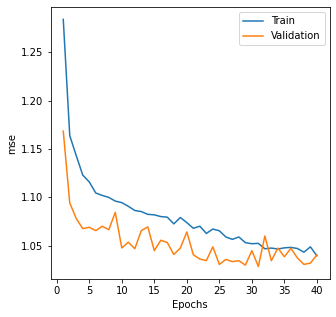

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curve(total_epoch=10, start=1) :
  plt.figure(figsize=(5, 5))
  plt.plot(range(start, total_epoch+1),
           history.history['loss'][start-1 : total_epoch],
           label='Train')
  plt.plot(range(start, total_epoch+1),
           history.history['val_loss'][start-1 : total_epoch],
           label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('mse')
  plt.legend()
  plt.show()

plot_loss_curve(total_epoch=40, start=1)

In [ ]:
model.evaluate(X_val, y_val)

26/26 [==============================] - 0s 1ms/step - loss: 1.0340 - acc: 0.5576 - mae: 0.1626


[1.0340144634246826, 0.5575757622718811, 0.16263556480407715]

In [ ]:
# test 데이터에 대한 예측값 정리
y_pred_proba = model.predict(X_test)
y_pred_proba[:5]

32/32 [==============================] - 0s 943us/step


array([[0.56669647, 0.01449465, 0.07589876, 0.09573483, 0.04248961,
        0.09964306, 0.10504255],
       [0.40615833, 0.00390374, 0.02418812, 0.04954151, 0.03880212,
        0.1782267 , 0.2991795 ],
       [0.54721254, 0.02009227, 0.09227871, 0.10072718, 0.04949555,
        0.09092066, 0.09927299],
       [0.51970774, 0.04605883, 0.14394656, 0.10612269, 0.05036254,
        0.0785709 , 0.05523082],
       [0.56338537, 0.01224285, 0.06977345, 0.08882631, 0.04561283,
        0.10292958, 0.1172296 ]], dtype=float32)

In [ ]:
y_pred_label = np.argmax(y_pred_proba, axis=-1) + 3 # 데이터 전처리시, 3을 감소시켰기 때문에 3을 더해서 복원.
y_pred_label[:5]

array([3, 3, 3, 3, 3])

In [ ]:
# 제출 양식에 맞게 정리
subm['quality'] = y_pred_label.astype(int)
subm.head()

# 제출 파일 저장
subm.to_csv('wine_dnn_.csv', index=False)